# New York City Airbnb

In [18]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import MarkerCluster

# Loading the dataset
df = pd.read_csv("AB_NYC_2019.csv")

# Displaying dataset info and basic overview
dataset_info = df.info()
first_rows = df.head()
summary_stats = df.describe(include='all')

# Data Validation
# Checking for missing values
missing_values = df.isnull().sum()

# Checking for duplicate rows
duplicates = df.duplicated().sum()

# Checking for outliers in key numeric columns
numeric_cols = ['price', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
outliers_summary = df[numeric_cols].describe()

# Displaying outputs
print("\nFirst rows: \n", first_rows)
print("\nSummary Stats: \n", summary_stats)
print("\nMissing values: \n", missing_values)
print("\nDuplicate values: \n", duplicates)
print("\nOutliers summary: \n", outliers_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [11]:
# Creating a copy of the original dataset
df_clean = df.copy()

# Removing listings with prices listed as 0
df_clean = df_clean[df_clean['price'] > 0]

# Removing listings with unrealistic minimum nights (e.g., more than 30)
df_clean = df_clean[df_clean['minimum_nights'] <= 30]

# Filling missing reviews_per_month with 0 (assumed no reviews)
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

# Dropping rows with missing host_name or listing name
df_clean = df_clean.dropna(subset=['host_name', 'name'])

# Converting last_review to datetime format
df_clean['last_review'] = pd.to_datetime(df_clean['last_review'], errors='coerce')

# Resetting index after filtering
df_clean.reset_index(drop=True, inplace=True)

# Displaying resulting dataset shape and sample data
print(df_clean.shape)
print(df_clean.head())

(48101, 16)
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1           

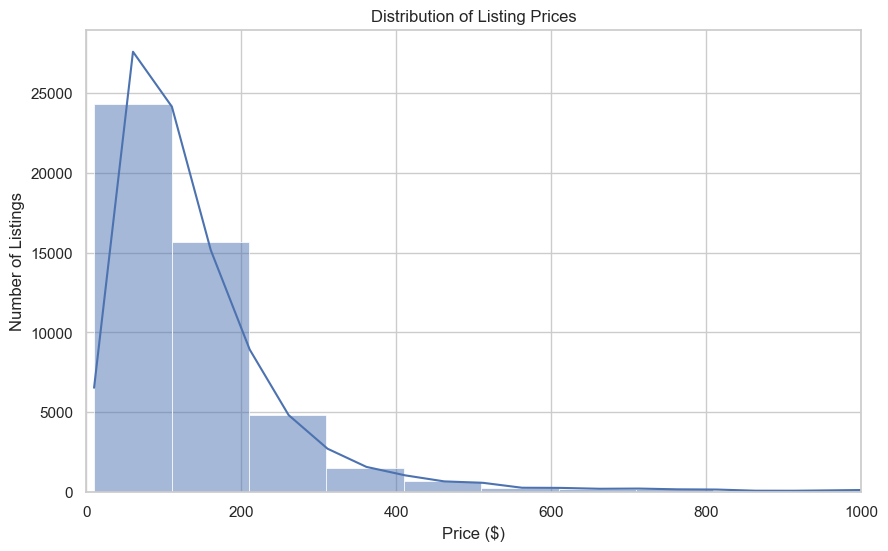

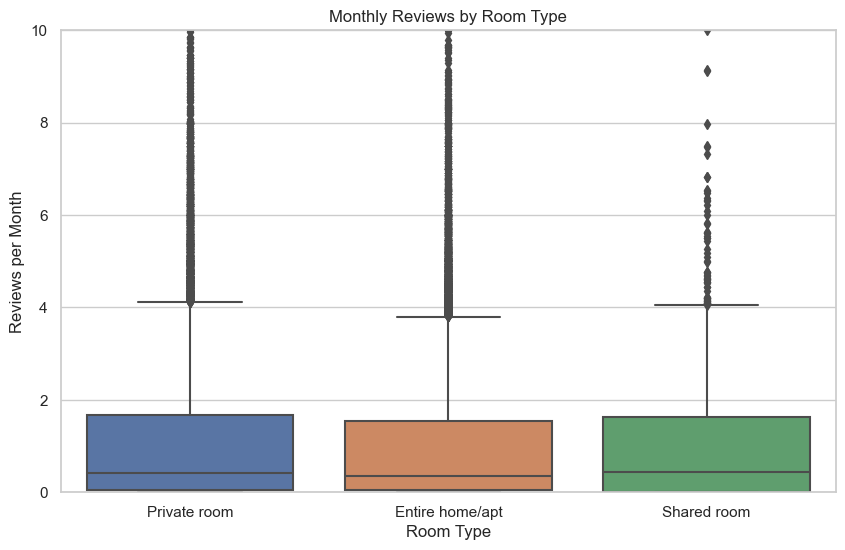

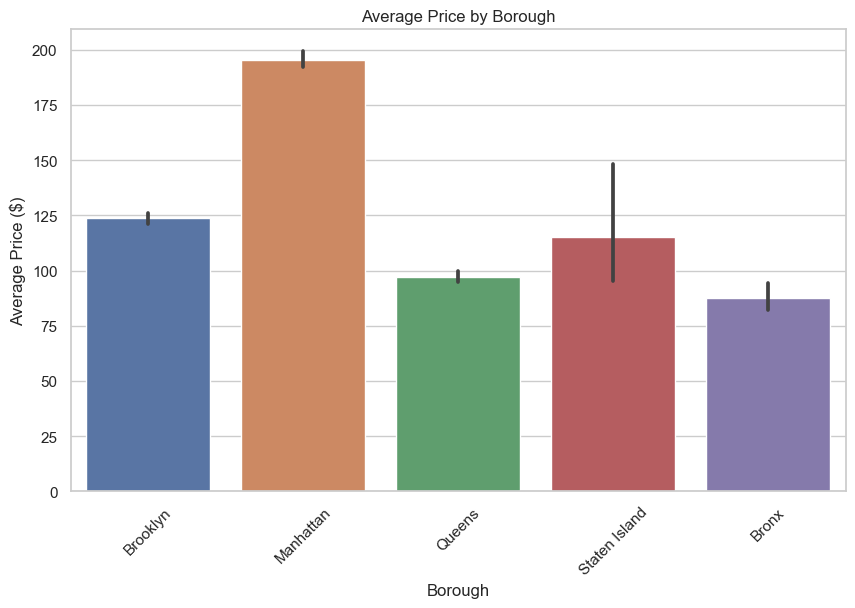

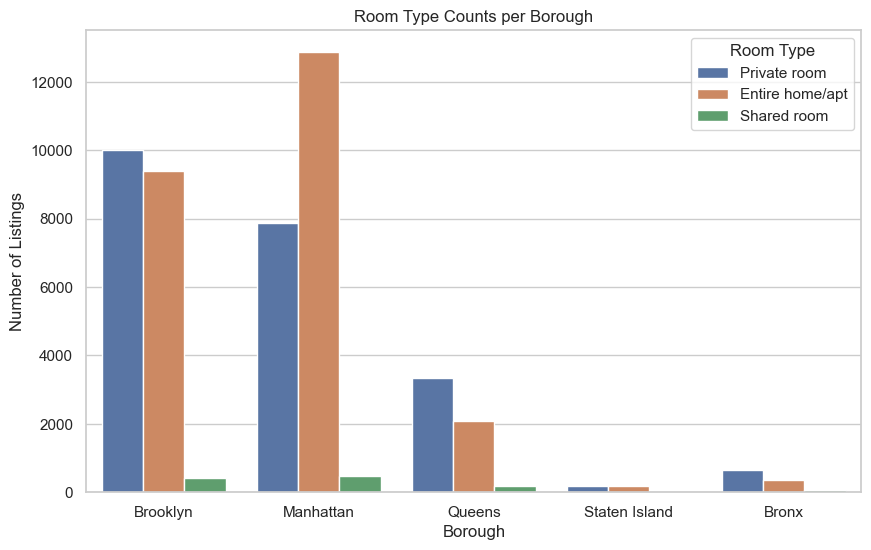

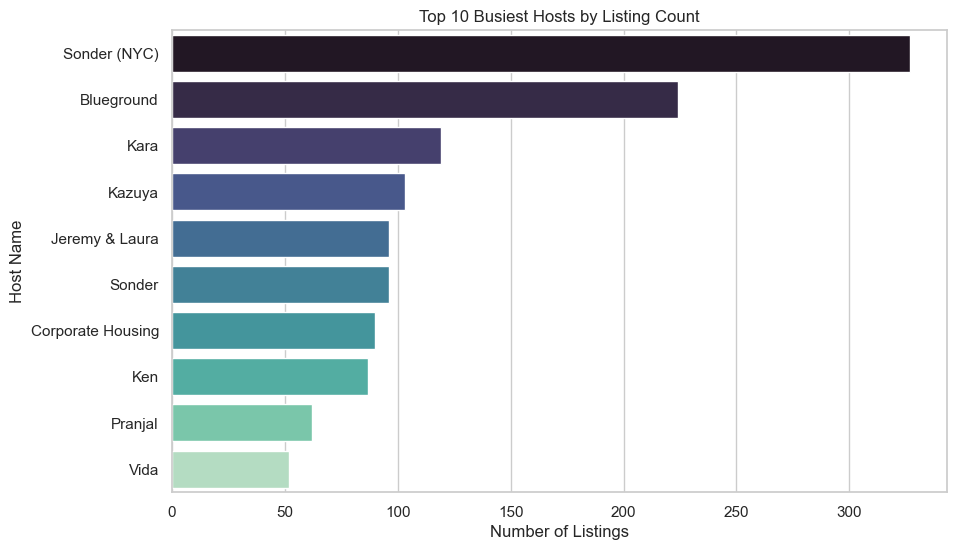

In [16]:
# Exploratory Data Analysis (EDA)

# 1. Distribution of prices (with extreme values shown)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['price'], bins=100, kde=True)
plt.title("Distribution of Listing Prices")
plt.xlabel("Price ($)")
plt.ylabel("Number of Listings")
plt.xlim(0, 1000)  # Zoom in to better understand typical prices
plt.show()

# 2. Boxplot of reviews_per_month by room type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='room_type', y='reviews_per_month')
plt.title("Monthly Reviews by Room Type")
plt.ylabel("Reviews per Month")
plt.xlabel("Room Type")
plt.ylim(0, 10)  # Focus on majority
plt.show()

# 3. Average price by neighbourhood group
plt.figure(figsize=(10, 6))
sns.barplot(data=df_clean, x='neighbourhood_group', y='price', estimator=np.mean)
plt.title("Average Price by Borough")
plt.ylabel("Average Price ($)")
plt.xlabel("Borough")
plt.xticks(rotation=45)
plt.show()

# Number of listings by room type and borough
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='neighbourhood_group', hue='room_type')
plt.title("Room Type Counts per Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Listings")
plt.legend(title="Room Type")
plt.show()

# Top 10 busiest hosts by number of listings
top_hosts = (
    df_clean.groupby(['host_id', 'host_name'])['id']
    .count()
    .reset_index()
    .rename(columns={'id': 'listing_count'})
    .sort_values(by='listing_count', ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_hosts, x='listing_count', y='host_name', palette='mako')
plt.title("Top 10 Busiest Hosts by Listing Count")
plt.xlabel("Number of Listings")
plt.ylabel("Host Name")
plt.show()

# Interactive map of a sample of listings
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
marker_cluster = MarkerCluster().add_to(map_nyc)

# Using a sample for performance
for _, row in df_clean.sample(1000).iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['name']} (${row['price']}) - {row['room_type']}"
    ).add_to(marker_cluster)

map_nyc